## **Importing Packages**

In [ ]:
pip install torchtext==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99

In [ ]:
#To Load Data in Colab
from google.colab import drive # Used to access Google Drive to import data
import shutil # Used to copy data from Google Drive

# General Packages
import pandas as pd
import numpy as np

#Working with Text
import re #To split text into words
from collections import Counter #To count words
from itertools import islice #To slice dictionary

#Removing Stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns

#Sklean
from sklearn.metrics.pairwise import cosine_similarity #Computing cosine similarity
from sklearn.cluster import KMeans #Clustering Embeddings of product names
from sklearn.decomposition import PCA #Reduce dimensionality of embeddings for visualization

#Pytorch
import torchtext

# **<u>Part 1: Word Embeddings with Word Co-Occurence Matrix</u>**

## **Step 1: Load Text Data**

In [ ]:
#Mount to Google Drive to be able to access data (images & labels)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define general path
path_dir = "/content/drive/My Drive/2) College & Other Education/1) College/1) Master of Science Data Science in Business & Economics/3. Semester/DS405B_Practical_Deep_Learning_for_Language_Processing/Assignments/Assignment 1"

In [ ]:
#Copy image data to local machine to allow for faster estimation.
shutil.copy(f"{path_dir}/Data/brown.txt", "brown.txt")

'brown.txt'

In [ ]:
with open("brown.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [ ]:
print("Total number of character:", len(raw_text))

Total number of character: 6086599


## **Step 2: Function: get_word_frequencies()**

In [ ]:
def get_word_frequencies(text):

  #Source: Lecture Notes
  words = re.split(r'([,.:;?_!"()\']|--|\s)', text)
  words = [item.strip() for item in words if item.strip()]

  #Source: https://stackoverflow.com/questions/49941646/python-counter-function-to-count-words-in-documents-with-more-then-one-occurre
  word_frequencies = Counter(words)

  return word_frequencies

## **Step 3: Function: create_vocab()**

In [ ]:
def create_vocab(word_frequencies, V):

  #Source: https://www.geeksforgeeks.org/python-most_common-function/
  top_V_words = word_frequencies.most_common(V)

  #We only need the words themself but not the frequencies
  most_common_words = [word for word, count in top_V_words]
  most_common_words.extend(["<|unk|>"]) #Adds two new special tokens

  #Assigns Index to each word (Source: Lecture Notes)
  vocab = {token:integer for integer, token in enumerate(most_common_words)}

  #Returns vocabulary of V most common words
  return vocab

## **Step 4: Function: windowizer()**

In [ ]:
def windowizer(text):
  #Splits the text
  words = re.split(r'([,.:;?_!"()\']|--|\s)', text)
  words = [item.strip() for item in words if item.strip()]

  #Creates empty list where the window will be stored
  window_list = []

  #Loops over range of words
  for i in range(len(words) - 1):

    #Creates current window as string with current (i) and next word (i + 1)
    current_window = f"{words[i]} {words[i + 1]}"

    #Appends word to list
    window_list.append(current_window)

  #Return list of windows
  return window_list


## **Step 5: Construct Word Co-Occurence Matrix for Brown Corpus**

In [ ]:
#Source: Lecture Notes
class SimpleTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]

        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        return text

In [ ]:
#Size of Vocabulary
V = 20000

word_frequencies = get_word_frequencies(raw_text)
vocab = create_vocab(word_frequencies, V)
tokenizer = SimpleTokenizer(vocab) #Creates functions to get index of word and vice versa
windows = windowizer(raw_text)

In [ ]:
# Target string to keep
target_string = ", and"

# Filter the list to keep only the target string
filtered_strings = [string for string in windows if string == target_string]

print(Counter(filtered_strings))

Counter({', and': 6255})


In [ ]:
embedding_matrix = np.zeros((V + 1, V + 1)) #First I create a matrix with zeros (+1 to account for unknown words)

for window in windows: #Loops over all windows
  word1, word2 = window.split() #Split the window into the two words

  i_word1 = tokenizer.encode(word1) #Get the index of word 1 in vocabulary
  i_word2 = tokenizer.encode(word2) #Get the index of word 2 in vocabulary

  #The the index in the vocabulary is used as index in the matrix.
  #I add +1 in count to the matrix for each coocurrance.
  #
  # The columns represent the alphabet and the rows each word.
  # The count value in the matrix is the total for a word being either word1 or word2.
  #
  # For example:
  #
  # The window "and of" is computed together with the window "of and".
  # It doesn't matter for the matrix in which order the words appear.
  #

  if i_word1 != i_word2:
    embedding_matrix[i_word1, i_word2] = embedding_matrix[i_word1, i_word2] + 1
    embedding_matrix[i_word2, i_word1] = embedding_matrix[i_word2, i_word1] + 1
  else:
    embedding_matrix[i_word1, i_word2] = embedding_matrix[i_word1, i_word2] + 1 #If the same words appear next to each other, I only add +1 once as there is only one field.

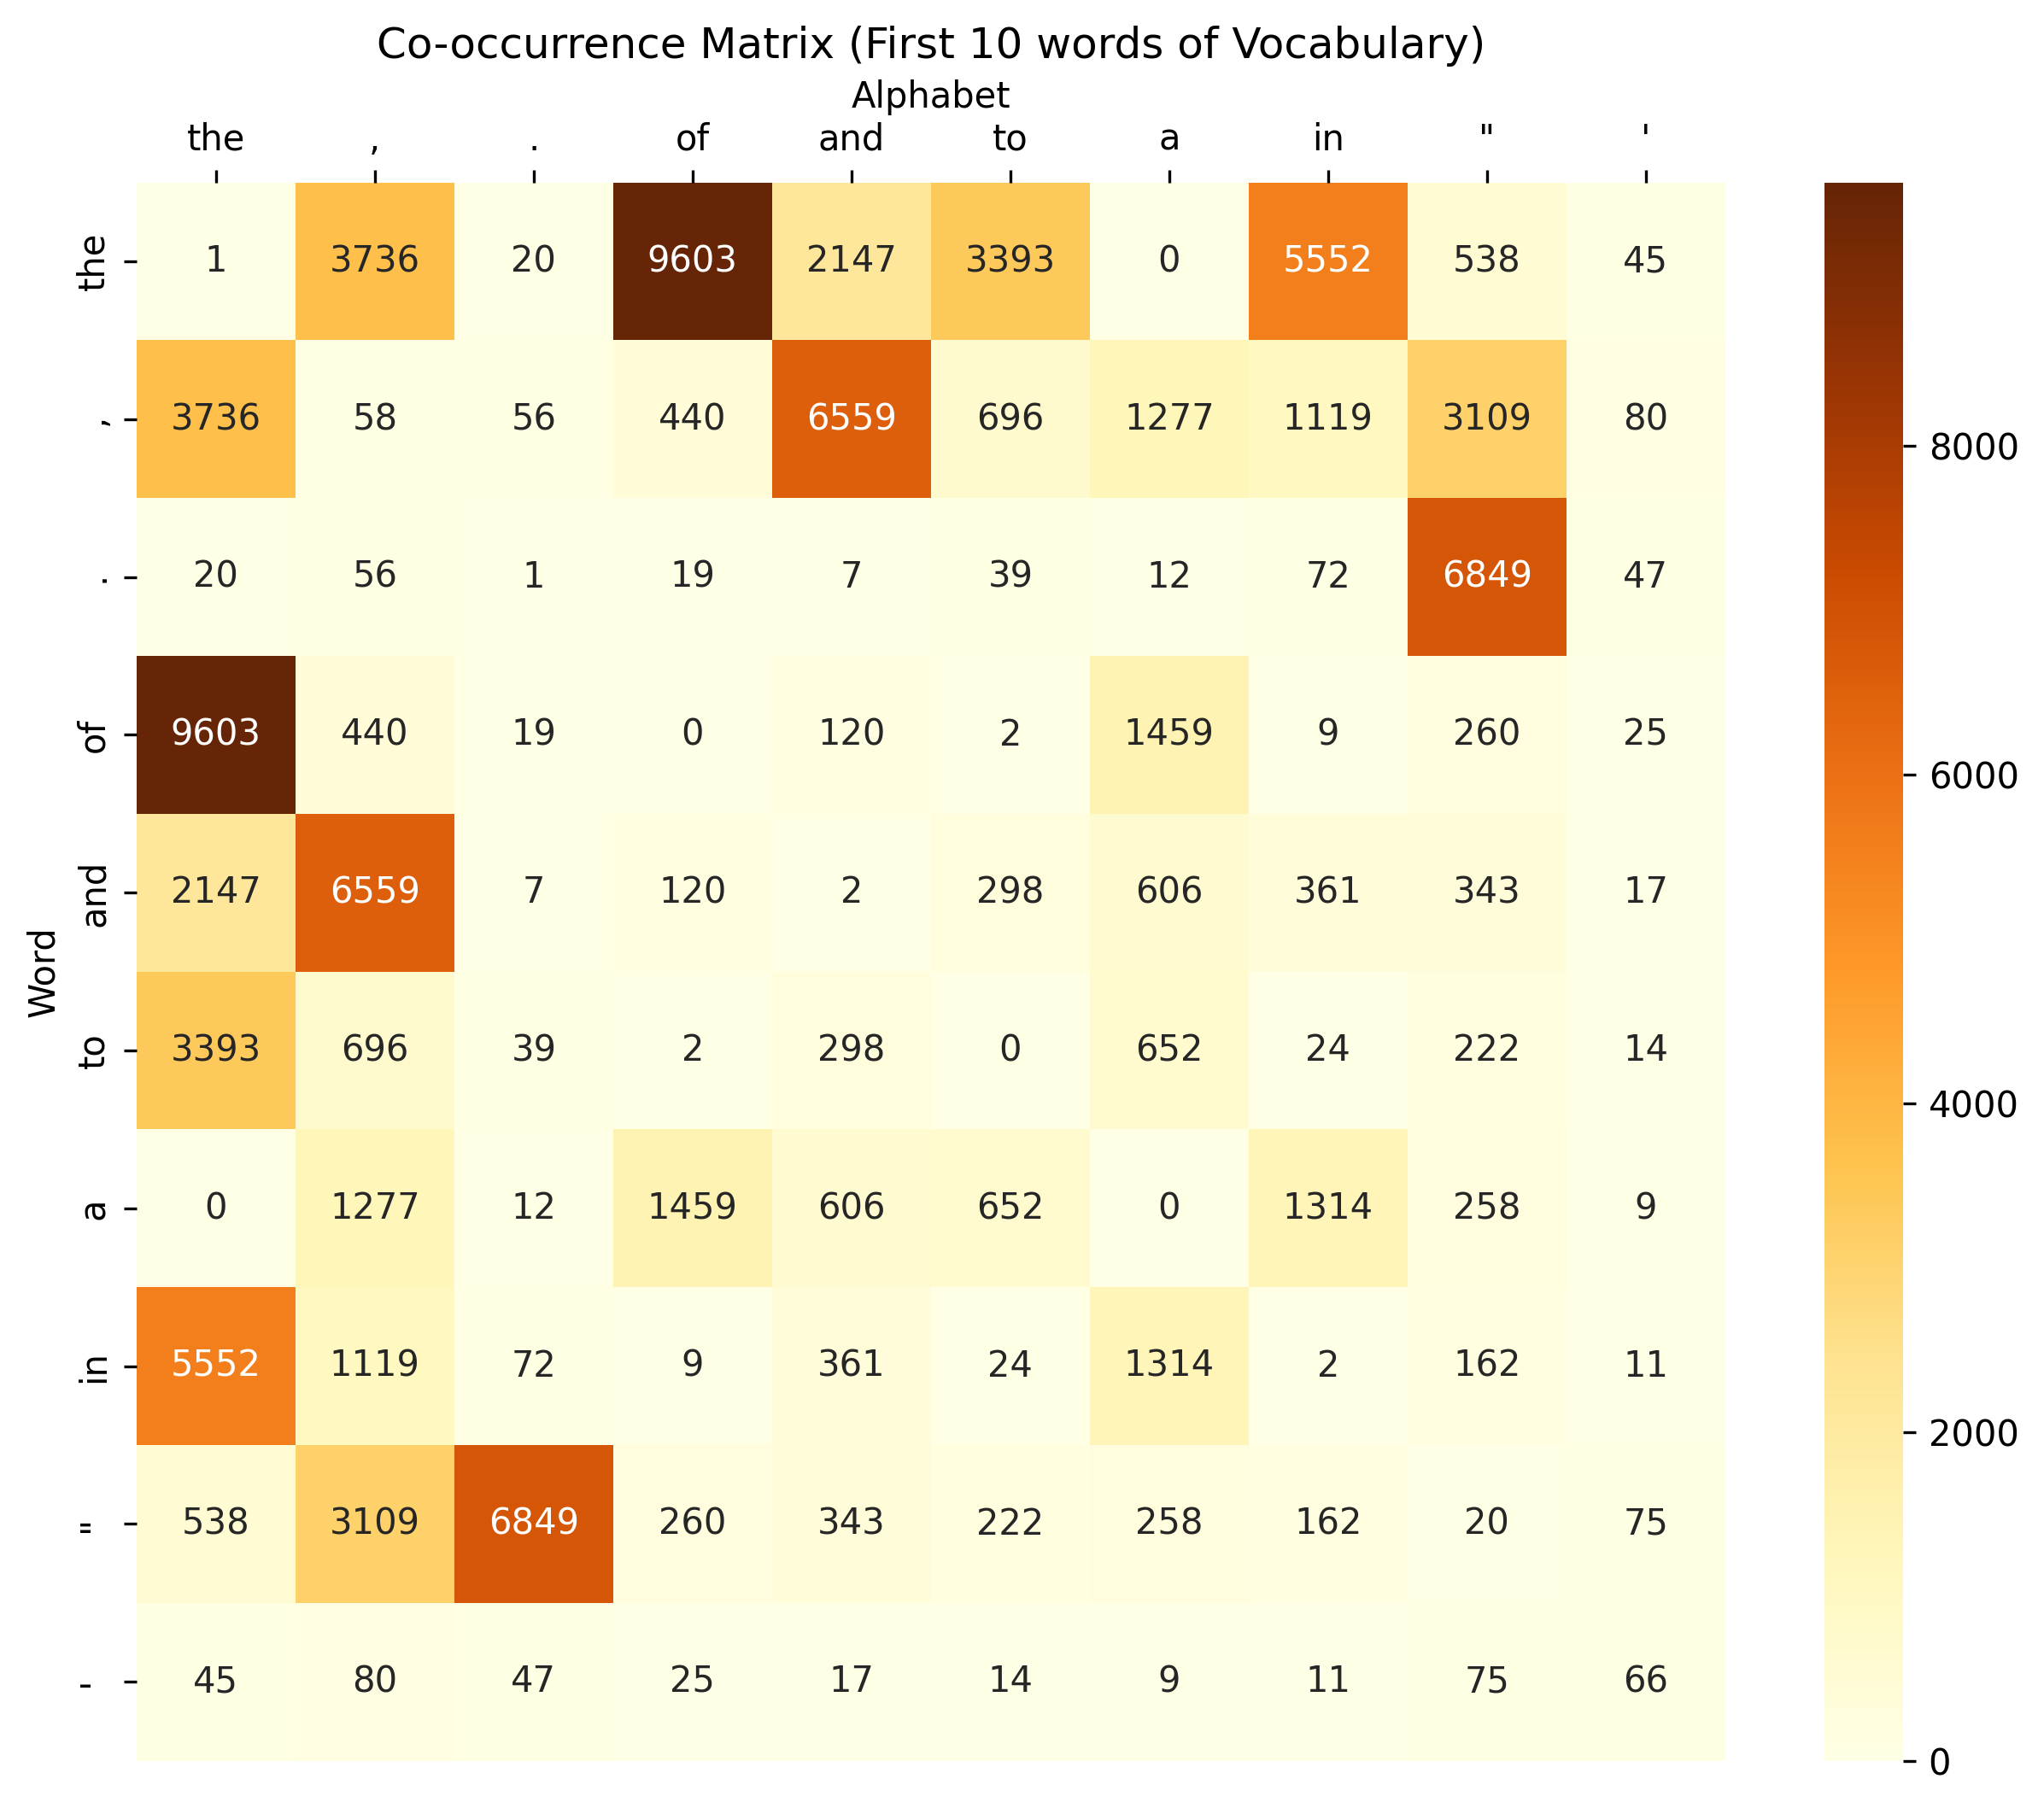

In [ ]:
#To see the result, I plot the first 10 words in a heatmap
first_10_matrix = embedding_matrix[:10, :10]
first_10_words = []

#Source: https://www.geeksforgeeks.org/python-get-first-k-items-in-dictionary/
for word, index in islice(vocab.items(), 10):
  first_10_words.append(word)

# Plotting the heatmap
plt.figure(figsize=(10, 8), dpi=300)

sns.heatmap(first_10_matrix,
            xticklabels = first_10_words,
            yticklabels = first_10_words,
            cmap = "YlOrBr", #Color scheme
            annot = True, # Adds values to cells
            fmt = ".0f") #Get rid of academic number formatting

# Move x-axis to top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

plt.title("Co-occurrence Matrix (First 10 words of Vocabulary)")
plt.xlabel("Alphabet")
plt.ylabel("Word")
plt.show()

## **Step 6: Function: most_similar_words()**

In [ ]:
def most_similar_words(embedding_matrix, vocab, test_word, top_n):
  if test_word not in vocab:
        return f"{test_word} is not in vocabulary!"

  # Get the index of the test word in the vocabulary
  test_word_index = vocab[test_word]

  # Get the embedding vector for the test word
  test_word_embedding = embedding_matrix[test_word_index]

  # Compute cosine similarity between the test word and all words in the vocabulary
  similarities = cosine_similarity([test_word_embedding], embedding_matrix).flatten()

  # -top_n-1:-1 -> Excludes the test word itself
  similar_indices = np.argsort(similarities)[-top_n-1:-1][::-1]
  top_similar_words = [word for word, index in vocab.items() if index in similar_indices]

  return similar_indices, top_similar_words

In [ ]:
most_similar_words(embedding_matrix, vocab, "of", 10)

(array([  29,    7,   25,  165,   20,  111,   26, 7117,   68,  157]),
 ['in',
  'on',
  'by',
  'at',
  'from',
  'into',
  'through',
  'under',
  'against',
  'slightest'])

# **<u>Part 2: Applications of Dense Representations of Words</u>**

# **<u>Task A - Fine-grained Supermarket Product Segmentation</u>**

## **Step 1: Importing Data**

In [ ]:
#Copy image data to local machine to allow for faster estimation.
shutil.copy(f"{path_dir}/Data/products.csv", "products.csv")
shutil.copy(f"{path_dir}/Data/aisles.csv", "aisles.csv")

'aisles.csv'

In [ ]:
products_original = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")

In [ ]:
products_original.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## **Step 2: Select Products**

In [ ]:
#Select any aisle
aisle = 22

#Subset data to only look at certified aisle
products_subsetted = products_original[products_original["aisle_id"] == aisle].copy().reset_index(drop = True)

In [ ]:
products_subsetted.head(10) #Prints product names before cleaning up.

,product_id,product_name,aisle_id,department_id
0,51,Sa Extra Hold Mousse Hair Styling,22,11
1,55,Lasting Color Shampoo,22,11
2,214,Argan Oil of Morocco Renewing Weightless Heali...,22,11
3,308,Advanced Haircare Color Vibrancy Nourishing Sh...,22,11
4,372,Moisture Rich Sweet Orange & Argan Conditioner,22,11
5,384,EverCurl Hydracharge Conditioner,22,11
6,412,Brazilian Keratin & Argan Oil Leave-In Conditi...,22,11
7,498,Daily Moisture Shampoo,22,11
8,523,Biotin & Collagen Shampoo,22,11
9,542,Medium to Firm Hold Hair Styling Foam,22,11


## **Step 3: Clean Up Product Name**

In [ ]:
def cleanupText(s):
    """
    Given a text, cleans. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«®\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')

    #I further remove some stuff as this later doesn't help with the clustering
    s = s.replace('.', '')
    s = s.replace(',', '')
    s = s.replace('-', '')
    s = s.replace(':', '')
    s = s.replace(';', '')
    s = s.replace('+', '')
    s = s.replace('*', '')
    return s

In [ ]:
products_subsetted["product_name_cleaned"] = products_subsetted["product_name"].apply(cleanupText)
products_subsetted.head(10)

,product_id,product_name,aisle_id,department_id,product_name_cleaned
0,51,Sa Extra Hold Mousse Hair Styling,22,11,sa extra hold mousse hair styling
1,55,Lasting Color Shampoo,22,11,lasting color shampoo
2,214,Argan Oil of Morocco Renewing Weightless Heali...,22,11,argan oil of morocco renewing weightless heali...
3,308,Advanced Haircare Color Vibrancy Nourishing Sh...,22,11,advanced haircare color vibrancy nourishing sh...
4,372,Moisture Rich Sweet Orange & Argan Conditioner,22,11,moisture rich sweet orange and argan conditi...
5,384,EverCurl Hydracharge Conditioner,22,11,evercurl hydracharge conditioner
6,412,Brazilian Keratin & Argan Oil Leave-In Conditi...,22,11,brazilian keratin and argan oil leave in co...
7,498,Daily Moisture Shampoo,22,11,daily moisture shampoo
8,523,Biotin & Collagen Shampoo,22,11,biotin and collagen shampoo
9,542,Medium to Firm Hold Hair Styling Foam,22,11,medium to firm hold hair styling foam


As you can see (For example form product_id 523), the "&" was replaced with a "and".

## **Step 4: Splitting Product Name into List of Words**

In [ ]:
#Source: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

#Download needed stuff.
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

def removeStopWords(product_name):
  word_tokens = word_tokenize(product_name.lower()) #Tokenize words
  filtered_product_name = [word for word in word_tokens if not word in stop_words]

  return filtered_product_name

#Apply function to each product name
products_subsetted["product_name_stop_words_removed"] = products_subsetted["product_name_cleaned"].apply(removeStopWords)

In [ ]:
products_subsetted.head(10)

,product_id,product_name,aisle_id,department_id,product_name_cleaned,product_name_stop_words_removed
0,51,Sa Extra Hold Mousse Hair Styling,22,11,sa extra hold mousse hair styling,"[sa, extra, hold, mousse, hair, styling]"
1,55,Lasting Color Shampoo,22,11,lasting color shampoo,"[lasting, color, shampoo]"
2,214,Argan Oil of Morocco Renewing Weightless Heali...,22,11,argan oil of morocco renewing weightless heali...,"[argan, oil, morocco, renewing, weightless, he..."
3,308,Advanced Haircare Color Vibrancy Nourishing Sh...,22,11,advanced haircare color vibrancy nourishing sh...,"[advanced, haircare, color, vibrancy, nourishi..."
4,372,Moisture Rich Sweet Orange & Argan Conditioner,22,11,moisture rich sweet orange and argan conditi...,"[moisture, rich, sweet, orange, argan, conditi..."
5,384,EverCurl Hydracharge Conditioner,22,11,evercurl hydracharge conditioner,"[evercurl, hydracharge, conditioner]"
6,412,Brazilian Keratin & Argan Oil Leave-In Conditi...,22,11,brazilian keratin and argan oil leave in co...,"[brazilian, keratin, argan, oil, leave, condit..."
7,498,Daily Moisture Shampoo,22,11,daily moisture shampoo,"[daily, moisture, shampoo]"
8,523,Biotin & Collagen Shampoo,22,11,biotin and collagen shampoo,"[biotin, collagen, shampoo]"
9,542,Medium to Firm Hold Hair Styling Foam,22,11,medium to firm hold hair styling foam,"[medium, firm, hold, hair, styling, foam]"


Now we have all the words in the product name as a list in the column product_name_cleaned without any stop words.

## **Step 5: Compute Word Vector Representations for every Word**

In [ ]:
data_dir = './'
fasttext = torchtext.vocab.FastText(language='en', cache=data_dir)
print('Loaded {} words'.format(len(fasttext.itos)))

./wiki.en.vec: 6.60GB [02:33, 42.9MB/s]                            
100%|██████████| 2519370/2519370 [09:25<00:00, 4452.83it/s]


Loaded 2519370 words


In [ ]:
#
# fasttext.itos = List with all the words
# fasttext["word"] = Embeddings of word
#
# Since the words in the column product_name_cleaned are lists of words,
# I will apply my function getWordEmbeddings to lists of words
#

def getWordEmbeddings(words):
  word_embeddings = []

  #This check is implemented to prevent Python to split a word into multiple letters if only 1 word is submitted.
  if len(words) == 1:
    if words[0] in fasttext.itos:
        #Append word embeddings of single word
        word_embeddings.append(fasttext[words[0]].tolist())
  else:
    #Loop over all words
    for word in words:
      #Check if word is in list of words from torchtext.vocab
      if word in fasttext.itos:
        #Append word embeddings of current word to list
        word_embeddings.append(fasttext[word].tolist())

  #Return list of embeddings
  return word_embeddings

In [ ]:
products_subsetted["product_name_element_embeddings"] = products_subsetted["product_name_stop_words_removed"].apply(getWordEmbeddings)

In [ ]:
products_subsetted["product_name_element_embeddings"].head()

,product_name_element_embeddings
0,"[[-0.6652299761772156, -0.20892000198364258, -..."
1,"[[0.12284000217914581, -0.08372700214385986, 0..."
2,"[[0.00019146999693475664, -0.208979994058609, ..."
3,"[[0.03760199993848801, 0.021642999723553658, -..."
4,"[[-0.6034299731254578, -0.020741000771522522, ..."


## **Step 6: Take Element Wise Mean of Word Embeddings**

In [ ]:
def getElementWiseEmbeddings(element_embeddings):
  #
  # Example: The product name has 6 lists of embeddings (As it has 6 words):
  #
  # [-0.6652299761772156, ...]
  # [-0.11218000203371048, ...]
  # [-0.006565299816429615, ...]
  # [0.1392199993133545, ...]
  # [0.10271000117063522, ...]
  # [-0.07946000248193741, ...]
  #
  # Each lit of embeddings is of length 300.
  #
  # By taking the element-wise mean of the word embeddings I now take the mean of the first value of
  # all 6 lists. This means that here these 6 values above (Each being in the first position of their respective list)
  # are averaged using np.mean(element_embeddings, axis = 0).
  #
  # The setting "axis = 0" makes sure that this is exactly what happens.
  #
  # As a result I get 1 list with length 300 containing the average value for each position.
  # Here the average for the first position is -0.103584213338
  #
  #
  return np.mean(element_embeddings, axis=0).tolist()

#Apply function to each product name
products_subsetted["product_name_mean_embedding"] = products_subsetted["product_name_element_embeddings"].apply(getElementWiseEmbeddings)

In [ ]:
#
# There are 300 embeddings for each product name consisting of the average embeddings of each word in the product name.
#
len(products_subsetted.loc[0, "product_name_mean_embedding"])

300

In [ ]:
#Average value of first position for first product name as described above
products_subsetted.loc[0, "product_name_mean_embedding"][0]

-0.10358421333755057

## **Step 7 & 8: K-Means Clustering & Experimenting with different Numbers of Clusters**

As there are no columns in the table that could give us a better idea about what category each product belongs to, I create category names based on the top 3 words contained in each cluster.

So if cluster one contains the word "conditionair", "hair" "color" most often while cluster 2 contains the word "hair" and "shampoo", "moist" then we can have some kind of idea what type of products are in one category.

In [ ]:
embeddings = np.array(products_subsetted["product_name_mean_embedding"].tolist())

cluster_range_start = 2
cluster_range_end = 8

top_words_matrix = []
top_word_count = 3

In [ ]:
#Performs K-Means Clustering for all the different number of clusters that we want to look at
for n_clusters in range(cluster_range_start, cluster_range_end + 1):

    kmeans = KMeans(n_clusters = n_clusters, random_state = 603) #Performs K-Means Clustering for the current number of clusters
    products_subsetted[f"cluster_{n_clusters}"] = kmeans.fit_predict(embeddings) #Predicts cluster for each product

    cluster_top_words = [] #Here I save the top 2 most often appearing words for each cluster

    #Loop over each cluster that we are currently looking at
    for cluster in range(n_clusters):

        #I first subset the data to only look at the current cluster
        cluster_members = products_subsetted[products_subsetted[f"cluster_{n_clusters}"] == cluster]

        #I then read all the words in the column "product_name_stop_words_removed"
        all_words = []

        for word_list in cluster_members["product_name_stop_words_removed"]:
            all_words.extend(word_list)

        #I count how often each word appears in the column
        word_count = Counter(all_words)

        #Now I read the two most occuring words.
        two_most_commong_words = word_count.most_common(top_word_count)

        #I save them together with the count of how often they appear in a list
        cluster_top_words.append([f"{word}: {count}" for word, count in two_most_commong_words])

    #I add the count of the words to a matrix
    top_words_matrix.append(cluster_top_words)

In [ ]:
matrix_data = []

#I loop over all k-means results for different amount of clusters (0 to 8)
for cluster_num in range(cluster_range_end):

    #I create a matrix row by row
    row = []

    #Now I loop over each cluster within a k-means result.
    for cluster in top_words_matrix:

        #If the number of clusters for the current k-means result is smaller than the total number of clusters considered
        #right now, I add the value ...
        if cluster_num < len(cluster):
            row.append(cluster[cluster_num])
        #... otherwise I just add None as there are no values to add
        else:
            row.append(None)

    #Once a row is complete I append it to the matrix
    matrix_data.append(row)

#Now I create a dataframe that has as columns the number of clusters considered and as rows the top 2 words for each cluster
columns = []

for i in range(len(top_words_matrix)):
    columns.append(f"cluster_{i+2}")

#Add this data to a dataframe
top_two_words_dataframe = pd.DataFrame(matrix_data, columns=columns)

#Adding + 1 to the idex so that the index represents the cluster number
top_two_words_dataframe["cluster"] = range(0, len(top_two_words_dataframe))

top_two_words_dataframe.head(10)

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster
0,"[conditioner: 232, hair: 133, shampoo: 102]","[conditioner: 174, moisture: 23, oil: 20]","[conditioner: 134, moisture: 21, hair: 13]","[conditioner: 119, moisture: 18, hair: 13]","[conditioner: 111, moisture: 18, hair: 13]","[conditioner: 100, hair: 15, smooth: 10]","[smooth: 28, conditioner: 24, shampoo: 16]",0
1,"[shampoo: 240, conditioner: 53, hair: 36]","[shampoo: 239, hair: 32, dry: 21]","[shampoo: 79, conditioner: 48, oil: 31]","[conditioner: 63, oil: 43, shampoo: 43]","[shampoo: 86, conditioner: 85, one: 61]","[shampoo: 122, conditioner: 68, one: 59]","[shampoo: 122, conditioner: 72, one: 58]",1
2,None,"[hair: 122, conditioner: 102, shampoo: 97]","[hair: 118, shampoo: 104, conditioner: 97]","[hair: 106, color: 68, conditioner: 54]","[hair: 93, color: 72, hold: 42]","[hair: 93, color: 73, hold: 43]","[shampoo: 58, conditioner: 55, oil: 34]",2
3,None,None,"[shampoo: 155, hair: 20, dry: 18]","[shampoo: 82, moisturizing: 13, moisture: 11]","[shampoo: 35, moisturizing: 10, moisture: 8]","[shampoo: 10, moisturizing: 4, dandruff: 2]","[color: 81, hair: 39, brown: 24]",3
4,None,None,None,"[shampoo: 190, one: 46, conditioner: 45]","[shampoo: 165, hair: 20, dry: 17]","[shampoo: 154, hair: 22, dry: 17]","[shampoo: 102, moisturizing: 13, dandruff: 12]",4
5,None,None,None,None,"[conditioner: 64, oil: 42, shampoo: 34]","[conditioner: 48, oil: 45, argan: 30]","[hold: 43, hair: 31, hairspray: 30]",5
6,None,None,None,None,None,"[conditioner: 44, moisture: 12, coconut: 9]","[hair: 53, shampoo: 20, conditioner: 10]",6
7,None,None,None,None,None,None,"[conditioner: 90, moisture: 19, daily: 9]",7


It is obvious that choosing 2 clusters is maybe not enough clusters as there is no ideal separation possible. We don't really know what separates the two categories.

If we look at 4 clusters, it becomes a little more clear.
The first cluster has something to do with conditioner that moisturizes. The second cluster is a shampoo and conditioner that have some kind of special oil in it possibly? The next two clusters however don't seem to be very informative in terms of their most used words. We don't know if it wouldn't maybe make sense to combine these categories or how much they actually overlap.

The more clusters we add the more distinct the categories become. With 5 clusters we now also see separation of items that have something to do with color.

However, based on this method it does not become clear what distinguishes each cluster specifically as with a growing number of clusters the names repeat again. Cluster 8 for example has multiple clusters using the word shampoo or the word conditioner.

Overall, this method doesn't seem to tell us on a first glance what features really separate each category.

## **Step 9: Provide Sub Category Names for each Cluster**

I decided to choose 6 clusters and create categories based on this. The category names will simply be the top 3 words used in each cluster.

In [ ]:
cluster_for_category_names = 6

top_words_cluster_six = top_two_words_dataframe[[f"cluster_{cluster_for_category_names}", "cluster"]].copy() #Copy only cluster that we want
top_words_cluster_six = top_words_cluster_six[top_words_cluster_six[f"cluster_{cluster_for_category_names}"].notna()] #Drop None rows

In [ ]:
top_words_cluster_six.head(10)

,cluster_6,cluster
0,"[conditioner: 111, moisture: 18, hair: 13]",0
1,"[shampoo: 86, conditioner: 85, one: 61]",1
2,"[hair: 93, color: 72, hold: 42]",2
3,"[shampoo: 35, moisturizing: 10, moisture: 8]",3
4,"[shampoo: 165, hair: 20, dry: 17]",4
5,"[conditioner: 64, oil: 42, shampoo: 34]",5


In [ ]:
#I combine all the words with a "-" and remove any numbers and other punctuation to only get the words themself.
def extractTopWords(text):
  return "-".join(re.findall(r"[a-zA-Z]+", str(text)))

In [ ]:
top_words_cluster_six["sub_categories"] = top_words_cluster_six[f"cluster_{cluster_for_category_names}"].apply(extractTopWords) #Apply function to get sub category names
top_words_cluster_six = top_words_cluster_six.rename(columns={f"cluster_{cluster_for_category_names}": "cluster_words", "cluster": f"cluster_{cluster_for_category_names}"}) #Rename columns for merging

In [ ]:
top_words_cluster_six.head(10)

,cluster_words,cluster_6,sub_categories
0,"[conditioner: 111, moisture: 18, hair: 13]",0,conditioner-moisture-hair
1,"[shampoo: 86, conditioner: 85, one: 61]",1,shampoo-conditioner-one
2,"[hair: 93, color: 72, hold: 42]",2,hair-color-hold
3,"[shampoo: 35, moisturizing: 10, moisture: 8]",3,shampoo-moisturizing-moisture
4,"[shampoo: 165, hair: 20, dry: 17]",4,shampoo-hair-dry
5,"[conditioner: 64, oil: 42, shampoo: 34]",5,conditioner-oil-shampoo


In [ ]:
#Merge cluster category names back to product dataset
products_subsetted_merged = pd.merge(products_subsetted, top_words_cluster_six, on = f"cluster_{cluster_for_category_names}", how = "outer")

#Get only product id and sub category
product_categories = products_subsetted_merged[["product_id", "sub_categories"]]

#Merge category back to original products dataset to get final dataset
products_final = pd.merge(products_original, product_categories, on = "product_id", how = "outer")

In [ ]:
products_final[products_final["aisle_id"] == aisle].head()

,product_id,product_name,aisle_id,department_id,sub_categories
50,51,Sa Extra Hold Mousse Hair Styling,22,11,hair-color-hold
54,55,Lasting Color Shampoo,22,11,shampoo-hair-dry
213,214,Argan Oil of Morocco Renewing Weightless Heali...,22,11,conditioner-oil-shampoo
307,308,Advanced Haircare Color Vibrancy Nourishing Sh...,22,11,hair-color-hold
371,372,Moisture Rich Sweet Orange & Argan Conditioner,22,11,conditioner-oil-shampoo


# **<u>Task B - Genre Classification with Movie Titles</u>**

## **Step 1 & 3: Compute Word Vector Representation of each Genre Name**

In [ ]:
genres_list = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'horror', 'romance', 'thriller']
genres = pd.DataFrame(genres_list, columns=['genre'])

In [ ]:
genres["genre_cleaned"] = genres["genre"].apply(cleanupText)
genres["genre_stop_words_removed"] = genres["genre_cleaned"].apply(removeStopWords)

In [ ]:
genres["genre_embeddings"] = genres["genre_stop_words_removed"].apply(getWordEmbeddings)
genres.head()

,genre,genre_cleaned,genre_stop_words_removed,genre_embeddings
0,action,action,[action],"[[-0.03329800069332123, -0.035356998443603516,..."
1,adventure,adventure,[adventure],"[[0.12369000166654587, -0.11392000317573547, 0..."
2,comedy,comedy,[comedy],"[[-0.15807999670505524, -0.318589985370636, -0..."
3,drama,drama,[drama],"[[-0.14110000431537628, -0.2248300015926361, -..."
4,fantasy,fantasy,[fantasy],"[[-0.027773000299930573, 0.22015999257564545, ..."


In [ ]:
#How many words
len(genres.loc[0, "genre_embeddings"])

1

In [ ]:
#How many embeddings per word
len(genres.loc[0, "genre_embeddings"][0])

300

## **Step 2 & 3: Compute Word Vector Representation of each Movie Name**

In [ ]:
movies_list = ['The Hangover', 'Shutter Island', 'Fight Club', 'Jumanji', 'Narcos', 'The Matrix', 'Rush Hour', 'The Mummy', 'Iron Man', 'Silence of the Lambs', 'Batman Begins', 'Spider Man', 'The Hobbit', 'Troy', 'Jurassic Park', 'Scary Movie', 'Mission Impossible', 'Ted', 'Eat Pray Love', 'The Notebook', 'Love Actually', 'The Terminal', 'Crazy Stupid Love', 'Twilight', 'The Martian', 'Pursuit of Happyness']
movies = pd.DataFrame(movies_list, columns=['movie'])

In [ ]:
movies["movie_cleaned"] = movies["movie"].apply(cleanupText)
movies["movie_stop_words_removed"] = movies["movie_cleaned"].apply(removeStopWords)

In [ ]:
movies["movie_embeddings"] = movies["movie_stop_words_removed"].apply(getWordEmbeddings)
movies.head()

,movie,movie_cleaned,movie_stop_words_removed,movie_embeddings
0,The Hangover,the hangover,[hangover],"[[0.06532199680805206, -0.12099999934434891, -..."
1,Shutter Island,shutter island,"[shutter, island]","[[-0.003987700212746859, 0.3071900010108948, 0..."
2,Fight Club,fight club,"[fight, club]","[[0.006016800180077553, -0.025306999683380127,..."
3,Jumanji,jumanji,[jumanji],"[[-0.1415500044822693, -0.029154999181628227, ..."
4,Narcos,narcos,[narcos],"[[0.3349500000476837, -0.07785499840974808, -0..."


In [ ]:
#Check that embeddings are correct
first_row = len(movies.loc[0, "movie_embeddings"])
second_row = len(movies.loc[1, "movie_embeddings"])

print(f"First row {first_row}")
print(f"Second row {second_row}")

First row 1
Second row 2


In [ ]:
#How many words
first_row = len(movies.loc[0, "movie_embeddings"][0])
second_row = len(movies.loc[1, "movie_embeddings"][0])

print(f"First Row Size {first_row}")
print(f"Second Row Size {second_row}")

First Row Size 300
Second Row Size 300


## **Step 4: Compute Cosine Similarity between Movie Title & Genre words**

In [ ]:
#Source: https://datastax.medium.com/how-to-implement-cosine-similarity-in-python-505e8ec1d823
def computeCosineSimilarity(vector_A, vector_B):
  # Calculate dot product
  dot_product = sum(a*b for a, b in zip(vector_A, vector_B))

  # Calculate the magnitude of each vector
  magnitude_A = sum(a*a for a in vector_A)**0.5
  magnitude_B = sum(b*b for b in vector_B)**0.5

  # Compute cosine similarity
  cosine_similarity = dot_product / (magnitude_A * magnitude_B)

  return cosine_similarity

In [ ]:
def assignGenre(genre, movie):

  genre_embeddings = genre["genre_embeddings"].tolist()
  genre_name = genre["genre_stop_words_removed"].tolist()

  movie_embeddings = movie["movie_embeddings"].tolist()
  movie_title = movie["movie_stop_words_removed"].tolist()

  cosine_similarities = []
  genres_assigned = []
  best_genres = []

  #I first loop over all the movies
  for movie_index in range(len(movie_embeddings)):

    cosine_similarities_movie = []
    genres_movie = []

    #Within each movie I then loop over all title words
    for title_index in range(0, len(movie_embeddings[movie_index])):

      cosine_similarities_per_title_words = []

      #Next I loop over all genres to compute the cosine similarity between the current title word and every genre
      for genre_index in range(len(genre_embeddings)):

        #I compute the cosine similarity between each genre and the current word of the current title.
        current_cosine_similarity = computeCosineSimilarity(movie_embeddings[movie_index][title_index], genre_embeddings[genre_index][0])

        cosine_similarities_per_title_words.append(current_cosine_similarity)

      #Gets the index with the highest cosine similarity
      max_cosine_similarity_index = cosine_similarities_per_title_words.index(max(cosine_similarities_per_title_words))

      #Gets the highest cosine similarity
      max_cosine_similarity_movie = max(cosine_similarities_per_title_words)

      #Gets the genre with the highest cosine similarity
      closest_genre = genre_name[max_cosine_similarity_index][0]

      #Add cosine similarities & genres to list
      cosine_similarities_movie.append(max_cosine_similarity_movie)
      genres_movie.append(closest_genre)

    #Append the data to a final list
    cosine_similarities.append(cosine_similarities_movie)
    genres_assigned.append(genres_movie)

    #Get the best matching genre as the genre with the highest cosine similarity
    best_matching_genre = genres_movie[cosine_similarities_movie.index(max(cosine_similarities_movie))]
    best_genres.append(best_matching_genre)

  #Return the 3 lists
  return cosine_similarities, genres_assigned, best_genres


In [ ]:
cosine_similarities, genres_assigned, best_genres = assignGenre(genres, movies)

In [ ]:
#Add new columns to the dataframe
movies["cosine_similarities"] = cosine_similarities
movies["possible_genres"] = genres_assigned
movies["best_matching_genre"] = best_genres #This column says which genre each movie belongs to.

In [ ]:
movies.head(10)

,movie,movie_cleaned,movie_stop_words_removed,movie_embeddings,cosine_similarities,possible_genres,best_matching_genre
0,The Hangover,the hangover,[hangover],"[[0.06532199680805206, -0.12099999934434891, -...",[0.36699449463025813],[comedy],comedy
1,Shutter Island,shutter island,"[shutter, island]","[[-0.003987700212746859, 0.3071900010108948, 0...","[0.2888997366216743, 0.2542416930944557]","[thriller, adventure]",thriller
2,Fight Club,fight club,"[fight, club]","[[0.006016800180077553, -0.025306999683380127,...","[0.29550605408291, 0.23630730131097183]","[action, comedy]",action
3,Jumanji,jumanji,[jumanji],"[[-0.1415500044822693, -0.029154999181628227, ...",[0.4984153800100955],[adventure],adventure
4,Narcos,narcos,[narcos],"[[0.3349500000476837, -0.07785499840974808, -0...",[0.3388535511148095],[thriller],thriller
5,The Matrix,the matrix,[matrix],"[[0.13481000065803528, 0.18082000315189362, -0...",[0.20023235898869754],[action],action
6,Rush Hour,rush hour,"[rush, hour]","[[0.35662999749183655, -0.2694700062274933, -0...","[0.2450382204554878, 0.31060210277664047]","[romance, comedy]",comedy
7,The Mummy,the mummy,[mummy],"[[0.3223100006580353, -0.13255000114440918, -0...",[0.44333018192159707],[horror],horror
8,Iron Man,iron man,"[iron, man]","[[-0.09626500308513641, 0.10960999876260757, -...","[0.16396087372189733, 0.2852029614054926]","[romance, thriller]",thriller
9,Silence of the Lambs,silence of the lambs,"[silence, lambs]","[[-0.11387000232934952, 0.027223000302910805, ...","[0.33733131178622955, 0.30590964077357713]","[thriller, thriller]",thriller
